In [ ]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import os
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import random

## Обучение на 4000 изображений

In [ ]:
# Параметры (можно менять) 
TRAIN_IMG_DIR = "Dataset/train/images"
TRAIN_LABEL_DIR = "Dataset/train/labels"

VAL_IMG_DIR = "Dataset/val/images"
VAL_LABEL_DIR = "Dataset/val/labels"

# сколько хотим взять
TRAIN_POS_N = 2000
TRAIN_NEG_N = 2000

VAL_POS_N = 250
VAL_NEG_N = 250

BATCH_SIZE = 8
KEEP_CLASS = 0  # класс сигареты

In [8]:
def get_pos_neg_files(img_dir, label_dir, keep_class=0):
    """Возвращает два списка имён файлов (jpg/png) — pos (есть класс keep_class) и neg (нет)."""
    pos, neg = [], []
    for img_name in os.listdir(img_dir):
        if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
            continue

        txt_name = os.path.splitext(img_name)[0] + ".txt"
        txt_path = os.path.join(label_dir, txt_name)
        if not os.path.exists(txt_path):
            # если .txt нет — считаем как негатив (нет сигареты)
            neg.append(img_name)
            continue

        has_cls = False
        with open(txt_path, "r") as f:
            for line in f:
                parts = line.strip().split()
                if not parts:
                    continue
                try:
                    cls = int(parts[0])
                except:
                    continue
                if cls == keep_class:
                    has_cls = True
                    break

        if has_cls:
            pos.append(img_name)
        else:
            neg.append(img_name)
    return pos, neg

In [ ]:
# Получаем списки для train и val
train_pos_all, train_neg_all = get_pos_neg_files(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, keep_class=KEEP_CLASS)
val_pos_all, val_neg_all     = get_pos_neg_files(VAL_IMG_DIR, VAL_LABEL_DIR, keep_class=KEEP_CLASS)

print("Всего доступных (train): pos =", len(train_pos_all), "neg =", len(train_neg_all))
print("Всего доступных (val):   pos =", len(val_pos_all),   "neg =", len(val_neg_all))


Всего доступных (train): pos = 5088 neg = 3037
Всего доступных (val):   pos = 257 neg = 338


In [10]:
# Перемешиваем и режем по нужному кол-ву (по факту можно добавить проверку на длину)
random.shuffle(train_pos_all)
random.shuffle(train_neg_all)
random.shuffle(val_pos_all)
random.shuffle(val_neg_all)

train_pos = train_pos_all[:TRAIN_POS_N]
train_neg = train_neg_all[:TRAIN_NEG_N]

val_pos = val_pos_all[:VAL_POS_N]
val_neg = val_neg_all[:VAL_NEG_N]

train_files = train_pos + train_neg
val_files = val_pos + val_neg

random.shuffle(train_files)
random.shuffle(val_files)

print("Финально для train взято:", len(train_files), "(pos,neg) =", len(train_pos), len(train_neg))
print("Финально для val   взято:", len(val_files),   "(pos,neg) =", len(val_pos),   len(val_neg))


Финально для train взято: 4000 (pos,neg) = 2000 2000
Финально для val   взято: 500 (pos,neg) = 250 250


In [11]:
class YoloCigaretteDataset(Dataset):
    def __init__(self, img_dir, label_dir, img_files, transform=None, keep_class=0):
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.img_files = img_files
        self.transform = transform
        self.keep_class = keep_class

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_name = self.img_files[idx]
        img_path = os.path.join(self.img_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        label_path = os.path.join(self.label_dir, os.path.splitext(img_name)[0] + ".txt")
        boxes = []
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                for line in f.readlines():
                    parts = line.strip().split()
                    if not parts:
                        continue
                    cls = int(parts[0])
                    if cls == self.keep_class:
                        cx, cy, w, h = map(float, parts[1:])
                        boxes.append([cx, cy, w, h])

        boxes = torch.tensor(boxes, dtype=torch.float32)
        if self.transform:
            img = self.transform(img)
        return img, boxes


In [ ]:
#Создаём датасеты и лоадеры 
train_dataset = YoloCigaretteDataset(TRAIN_IMG_DIR, TRAIN_LABEL_DIR, train_files, transform=None, keep_class=KEEP_CLASS)
val_dataset   = YoloCigaretteDataset(VAL_IMG_DIR,   VAL_LABEL_DIR,   val_files,   transform=None, keep_class=KEEP_CLASS)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,  collate_fn=lambda batch: tuple(zip(*batch)))
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False, collate_fn=lambda batch: tuple(zip(*batch)))


In [13]:
def visualize_random_samples(dataset, n=8, figsize=(14, 14)):
    """
    Показывает n случайных изображений из любого YOLO датасета.
    Использует dataset[i] -> (img, boxes)
    """
    idxs = random.sample(range(len(dataset)), n)

    cols = 4
    rows = (n + cols - 1) // cols

    plt.figure(figsize=figsize)

    for i, idx in enumerate(idxs, 1):
        img, boxes = dataset[idx]

        # Преобразуем изображение в numpy
        if torch.is_tensor(img):
            img_np = img.permute(1, 2, 0).numpy()
        else:
            img_np = np.array(img)

        h, w = img_np.shape[:2]

        ax = plt.subplot(rows, cols, i)
        ax.imshow(img_np)
        ax.set_title(f"idx={idx}, boxes={len(boxes)}")
        ax.axis("off")

        # рисуем боксы
        for (cx, cy, bw, bh) in boxes:
            cx *= w
            cy *= h
            bw *= w
            bh *= h

            x1 = cx - bw / 2
            y1 = cy - bh / 2

            rect = patches.Rectangle(
                (x1, y1),
                bw,
                bh,
                linewidth=2,
                edgecolor='red',
                facecolor='none'
            )
            ax.add_patch(rect)

    plt.tight_layout()
    plt.show()

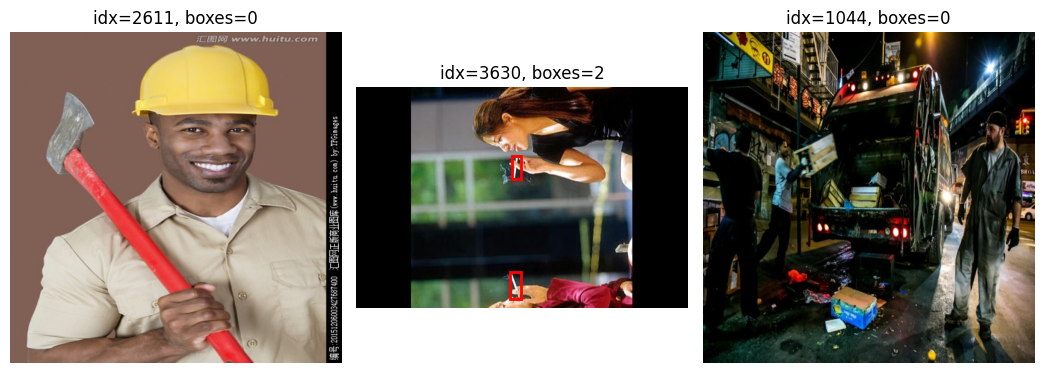

In [14]:
visualize_random_samples(train_dataset, n=3)


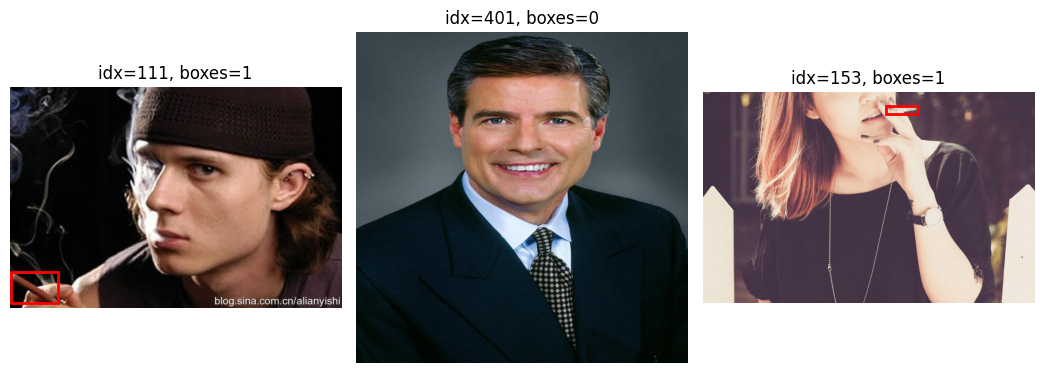

In [15]:
visualize_random_samples(val_dataset, n=3)


In [16]:
import ultralytics
ultralytics.__version__


'8.3.237'

In [ ]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")  # скачает автоматически

model.train(
    data="Dataset/data.yaml",
    epochs=20,
    imgsz=320,
    batch=16,
    workers=4,
    device=0,       # GPU, "cpu" если нет CUDA
    name="cigarette_yolov9n",
    augment=True,   # включаем базовые аугментации
    mosaic=False,   # отключаем мозаики
    mixup=False,     # отключаем миксап
    cache=True
)


Ultralytics 8.3.237  Python-3.11.6 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce GTX 1650, 4096MiB)
engine\trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Dataset/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=320, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=False, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=False, multi_scale=False, name=cigarette_yolov9n, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001F510FB75D0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.0480